# LetsGrowMore - More Advanced Level Task4

### ML Facial recognition to detect mood and suggest songs accordingly

### Batch - May 2022 - Data Science Intern

Dataset Link Provided - https://www.kaggle.com/datasets/msambare/fer2013

### 1) Importing The Necessary Libraries

In [1]:
import numpy as np
import cv2
import os
import random
from skimage.io import imread
import pandas as pd
import seaborn as sb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import Audio

### 2) Analyzing The Train & Test Sets

In [2]:
train_dir = r'C:\Users\hp\Downloads\MAL_Task4\train'
test_dir = r'C:\Users\hp\Downloads\MAL_Task4\test'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path +"/" +expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


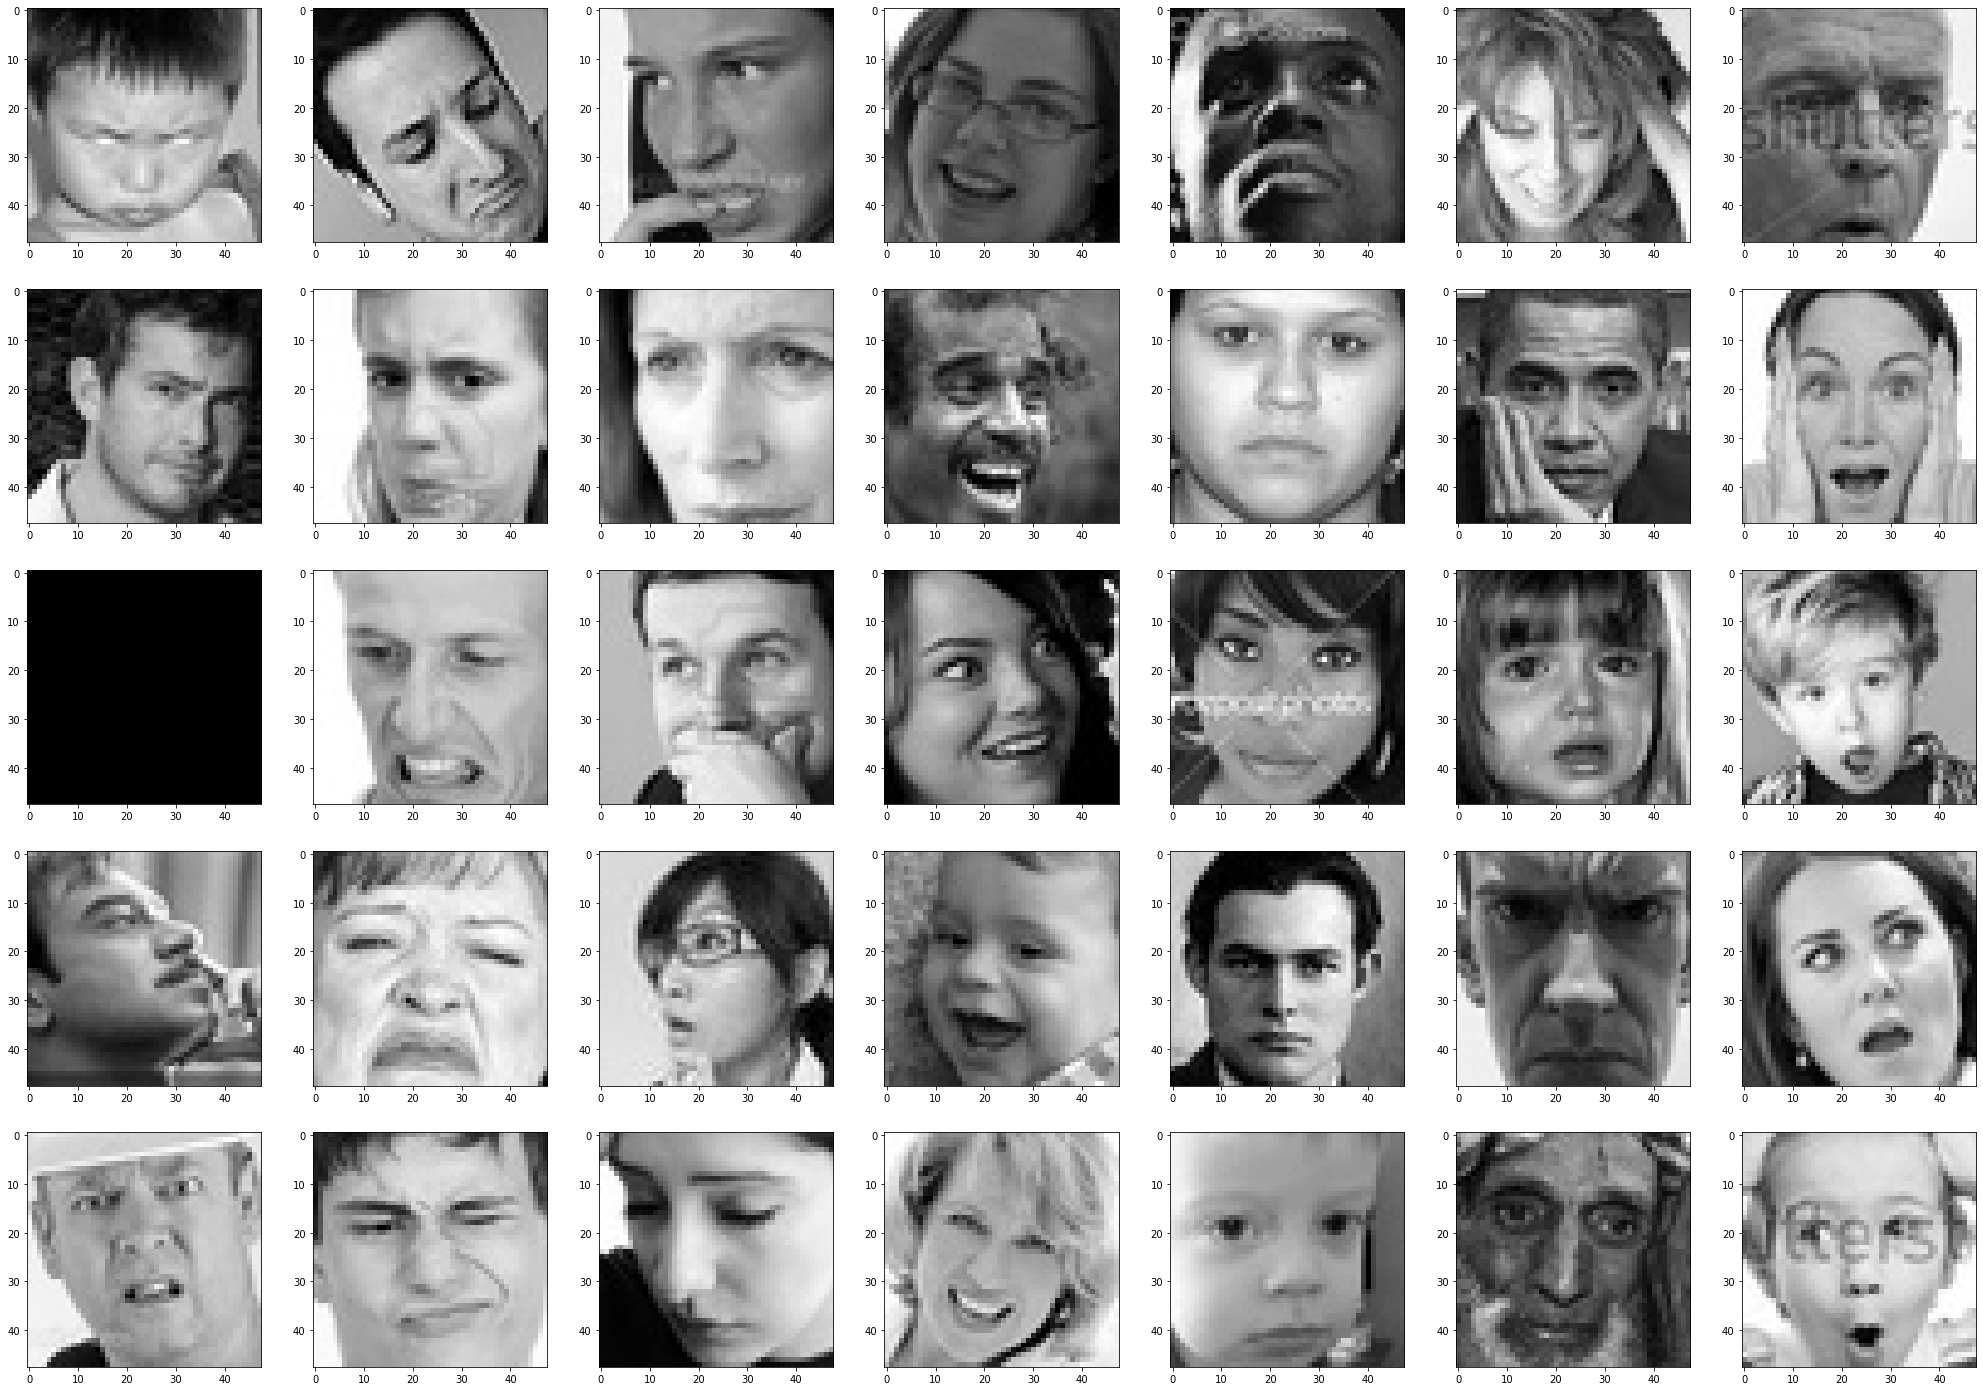

In [3]:
from skimage.io import imread
train_dir = "C:\\Users\\hp\\Downloads\\MAL_Task4\\train\\"
test_dir = "C:\\Users\\hp\\Downloads\\MAL_Task4\\test\\"
total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows=5, ncols=total_labels, figsize=(35, 25))
for x in range(5):
    for y,v in zip(range(total_labels),os.listdir(train_dir)):
        ax[x][y].imshow(imread(train_dir+v+'/'+os.listdir(train_dir+v)[x]), cmap='gray')

plt.show()

### 3) Visualizing The Dataset

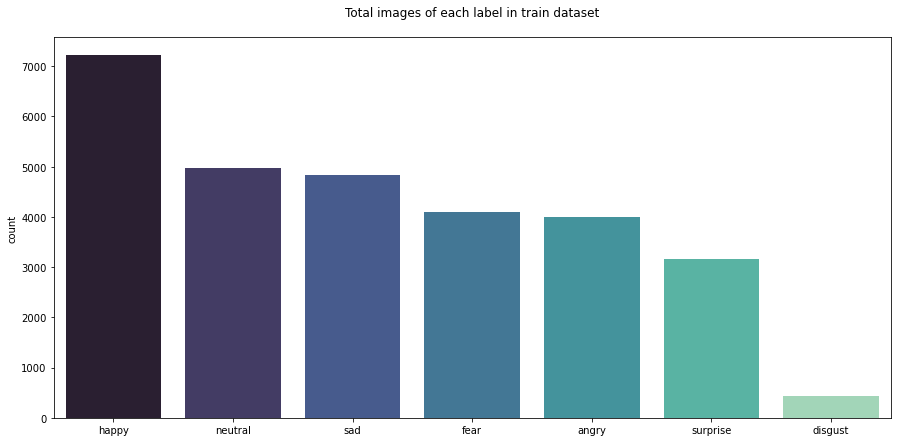

In [4]:
df = {}
for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(15,7))
sb.barplot(x=df.index, y="total", palette="mako", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset\n")
plt.show()

C:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


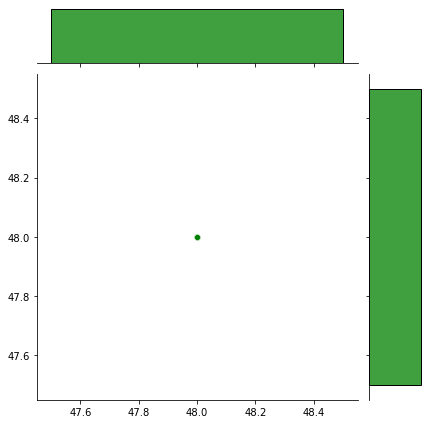

In [5]:
happy = os.listdir(train_dir+'happy/')
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir+'happy/'+img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)
sb.jointplot(dim1, dim2,color='g')
plt.show()

### 4) Building A Suitable ML Model

In [6]:
train_gen = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

In [8]:
model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
steps_per_epoch = train_generator.n 
validation_steps = test_generator.n 
num_epochs = 20

history = model.fit(train_generator,
                    epochs=num_epochs,
                    verbose=1,
                    #callbacks=callbacks,
                    validation_data=test_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/20
448/448 [==============================] - 490s 1s/step - loss: 1.8748 - accuracy: 0.2313 - val_loss: 2.3436 - val_accuracy: 0.1927
Epoch 2/20
448/448 [==============================] - 479s 1s/step - loss: 1.8024 - accuracy: 0.2477 - val_loss: 1.7536 - val_accuracy: 0.2748
Epoch 3/20
448/448 [==============================] - 479s 1s/step - loss: 1.7865 - accuracy: 0.2522 - val_loss: 1.7524 - val_accuracy: 0.2819
Epoch 4/20
448/448 [==============================] - 481s 1s/step - loss: 1.7738 - accuracy: 0.2621 - val_loss: 1.7232 - val_accuracy: 0.3108
Epoch 5/20
448/448 [==============================] - 478s 1s/step - loss: 1.7585 - accuracy: 0.2784 - val_loss: 1.8037 - val_accuracy: 0.3002
Epoch 6/20
448/448 [==============================] - 486s 1s/step - loss: 1.7382 - accuracy: 0.2918 - val_loss: 1.6527 - val_accuracy: 0.3421
Epoch 7/20
448/448 [==============================] - 456s 1s/step - loss: 1.7036 - accuracy: 0.3095 - val_loss: 1.7975 - val_accuracy: 0.3500

In [10]:
model.save("model.h5")

In [11]:
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

113/113 [==============================] - 20s 181ms/step - loss: 1.2300 - accuracy: 0.5167
validation accuracy : 51.671773195266724%
validation loss : 1.2300218343734741


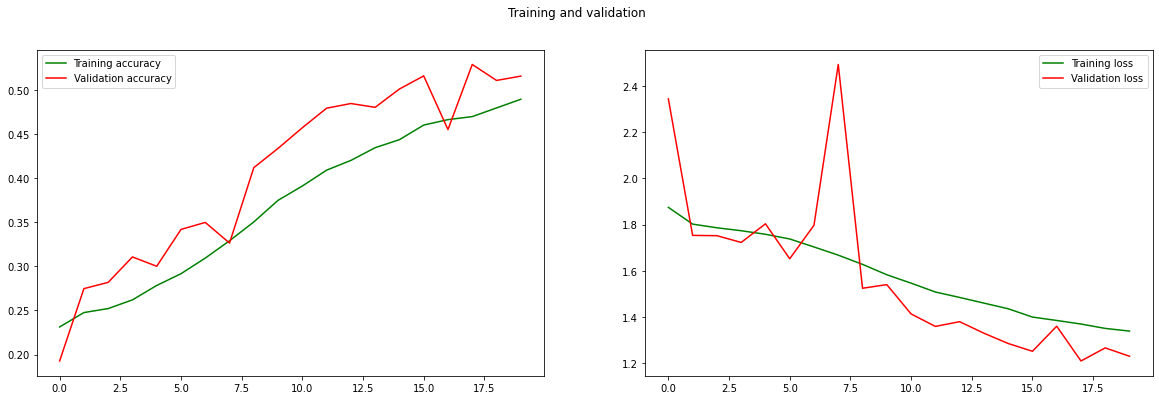

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'g', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'g', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

              precision    recall  f1-score   support

       angry       0.37      0.56      0.44       958
     disgust       0.50      0.01      0.02       111
        fear       0.37      0.11      0.17      1024
       happy       0.62      0.88      0.73      1774
     neutral       0.51      0.45      0.48      1233
         sad       0.44      0.24      0.31      1247
    surprise       0.57      0.77      0.66       831

    accuracy                           0.52      7178
   macro avg       0.48      0.43      0.40      7178
weighted avg       0.49      0.52      0.48      7178





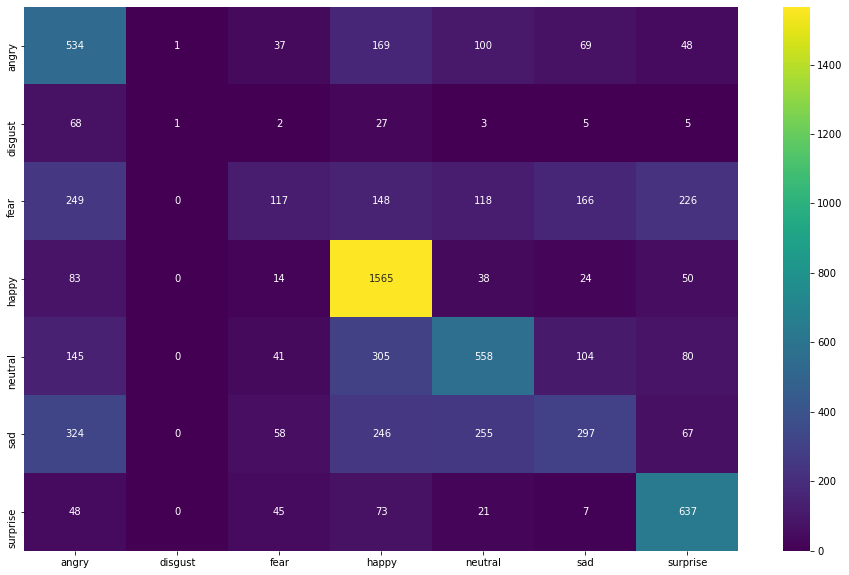

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(16,10))
sb.heatmap(cm, cmap=plt.cm.viridis, annot=True, fmt='.0f', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

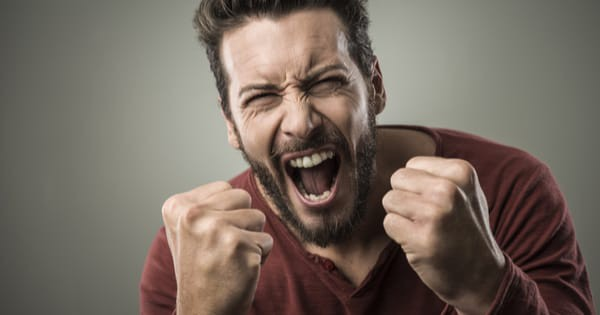

In [26]:
image = cv2.imread("C:\\Users\\hp\\Downloads\\MAL_Task4\\angry.jpg")
from IPython.display import Image
Image(filename='C:\\Users\\hp\\Downloads\\MAL_Task4\\angry.jpg')

In [27]:
import cv2
from tensorflow.python.keras.models import load_model
import os

#### LOADING THE TRAINED MODEL

In [28]:
model = tf.keras.models.load_model("model.h5",
    custom_objects={'Functional':tf.keras.models.Model})

EMOTIONS = ['Angry', 'Disgust', 'Happy', 'Sad', 'Surprise', 'Neutral']

img = image

frame = cv2.resize(img,(48,48),interpolation=cv2.INTER_BITS2)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0

gray = gray.reshape(1,48,48,1)

predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]
for (i,j) in zip(range(7),EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j)+"prediction rate is   {0:.2f}%".format(predictss))
print( "\n\n The system considers this expression to be:",label)

  Angry   prediction rate is   0.26%
 Disgust  prediction rate is   0.01%
  Happy   prediction rate is   0.10%
   Sad    prediction rate is   0.22%
 Surprise prediction rate is   0.21%
 Neutral  prediction rate is   0.18%


 The system considers this expression to be: Angry


In [29]:
model = tf.keras.models.load_model("model.h5", custom_objects={'Functional':tf.keras.models.Model})

EMOTIONS = ['Angry', 'Disgust', 'Happy', 'Sad', 'Surprise', 'Neutral']

img = image

frame = cv2.resize(img,(48,48),interpolation=cv2.INTER_BITS2)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0

gray = gray.reshape(1,48,48,1)

predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]
for (i,j) in zip(range(7),EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j)+"prediction rate is   {0:.2f}%".format(predictss))
print( "\n\n The system considers this expression to be:",label)

  Angry   prediction rate is   0.26%
 Disgust  prediction rate is   0.01%
  Happy   prediction rate is   0.10%
   Sad    prediction rate is   0.22%
 Surprise prediction rate is   0.21%
 Neutral  prediction rate is   0.18%


 The system considers this expression to be: Angry


In [30]:
if (label=='Angry'):
    path="C:\\Users\\hp\\Downloads\\MAL_Task4\\Angry\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='C:\\Users\\hp\\Downloads\\MAL_Task4\\Angry\\'+ d,autoplay=True)
    display(audio)
    
elif (label=='Disgust'):
    path="C:\\Users\\hp\\Downloads\\MAL_Task4\\Disgust\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='C:\\Users\\hp\\Downloads\\MAL_Task4\\Disgust\\'+ d,autoplay=True)
    display(audio)
    
elif (label=='Happy'):
    path="C:\\Users\\hp\\Downloads\\MAL_Task4\\Happy\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='C:\\Users\\hp\\Downloads\\MAL_Task4\\Happy\\'+ d,autoplay=True)
    display(audio)
    
elif (label=='Sad'):
    path="C:\\Users\\hp\\Downloads\\MAL_Task4\\Sad\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='C:\\Users\\hp\\Downloads\\MAL_Task4\\Sad\\'+ d,autoplay=True)
    display(audio)
    
elif (label=='Surprise'):
    path="C:\\Users\\hp\\Downloads\\MAL_Task4\\Surprise\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='C:\\Users\\hp\\Downloads\\MAL_Task4\\Surprise\\'+ d,autoplay=True)
    display(audio)

elif (label=='Neutral'):
    path="C:\\Users\\hp\\Downloads\\MAL_Task4\\Neutral\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='C:\\Users\\hp\\Downloads\\MAL_Task4\\Neutral\\'+ d,autoplay=True)
    display(audio)

Now Playing: sport-extreme-18389.mp3


### CONCLUSION

An ML Model was built successfully, which helped to predict an emotion accurately and play song accordingly using the given dataset.